In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import analysis_helpers as ah
import seaborn as sns
import warnings
from surprise import SVD, SVDpp, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split

warnings.filterwarnings('ignore')
rus_master_loc = '/Users/colinbrochard/DSI_Capstone_local/MtProjRec/2_data/3_rus/rusfiles/rus_master.csv'
np.random.seed(2)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mountain Project Recommender Analysis

### Read RUS data into DF and generate samples
Here we read in "Route User Star" data. Each row contains a user route combination and the rating that a user gave to the route on a 4-star scale. We also generat two random samples:
 - `df_sample`: takes a random 100k rows out of the original 1.4M row dataframe
 - `df_better_sample`: samples ~1/3 of the users and routes contained in the original df and then returns the df for just those routes and users. We will see why this is the 'better' sample below. Note that with fewer routes and users than we selected since dropping some user rows will take out some routes and visa versa.

In [182]:
df = pd.read_csv(rus_master_loc)[['user','route','num_stars']]
df_sample = df.sample(100000)
df_better_sample = ah.better_sample(df,12000,32000)

In [183]:
ah.unq_u_r(df_better_sample)

(9594, 25149)

### Matrix Stats
Take a look at the density figures below and note that the matrix becomes *much more sparse* `in df_sample`, whereas `df_better_sample` is more comparable. Therefore we will use `df_better_sample` to do our model tuning in the event we need a smaller sample to reduce computation time.

In [133]:
ah.pr_mat_stats(df,'Original Matrix Stats')

Original Matrix Stats
---------------------
matrix size: 3352747324
matrix shape: users 85871, routes 39044
matrix density: 0.00044089156060720785


In [134]:
ah.pr_mat_stats(df_sample,'Sample Matrix Stats')

Sample Matrix Stats
---------------------
matrix size: 676788360
matrix shape: users 36822, routes 18380
matrix density: 0.00014775667832112242


In [135]:
ah.pr_mat_stats(df_better_sample, 'Better Sample Matrix Stats')

Better Sample Matrix Stats
---------------------
matrix size: 243725073
matrix shape: users 25449, routes 9577
matrix density: 0.0007001454462586211


### Distributions
- Users:
    - About half have rated 5 or fewer routes.
    - Users who rate more than 10 are likely to rate many more
- Routes:
    - About half of our routes have been rated by 5 our fewer. 
    - However, unlike routes, we continue to lose more routes as we raise our threshold

In [123]:
#try to normalize these hists

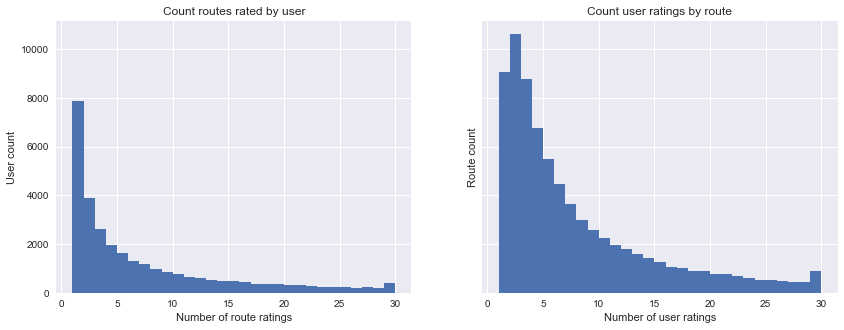

In [81]:
ah.plt_count_hists(df)

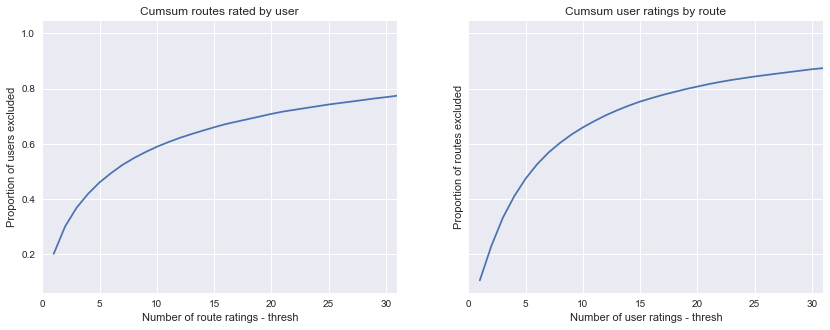

In [14]:
ah.plt_cumsum(df)

### Cold-start threshold and Matrix Density
Raising the cold-start threshold for both users and routes significantly increases the density of our matrix.
 - Intuatively, a denser matrix should be easier to predict (fewer black spots to fill) and improve the RMSE of our model.
 - It's worth noting that if we cut our threshold for both routes and users, with some users and routes who are pushed back under our cold-start threshold.

In [130]:
ah.pr_mat_stats(ah.rus_chop(df,10,10))

Matrix Stats
---------------------
matrix size: 527329536
matrix shape: users 31488, routes 16747
matrix density: 0.0022921947614935037


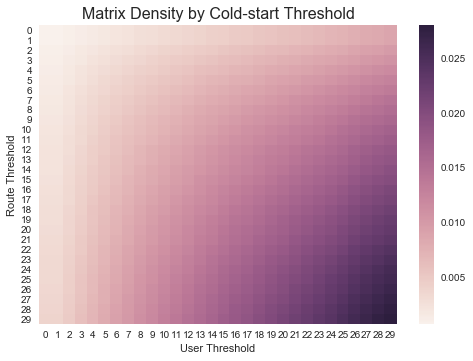

In [117]:
ah.thresh_heatmap(rus_density_thresh,"Matrix Density by Cold-start Threshold")

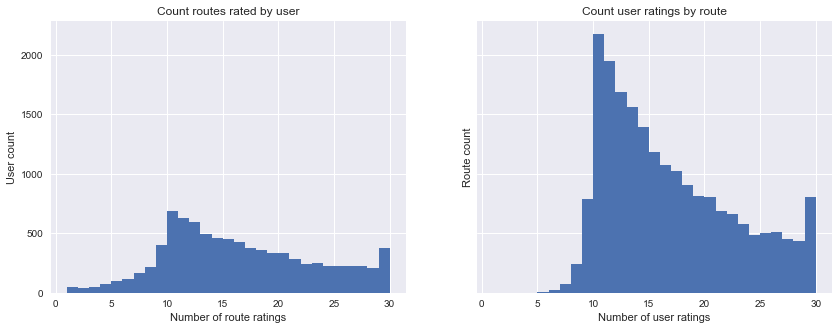

In [145]:
ah.plt_count_hists(ah.rus_chop(df,10,10))

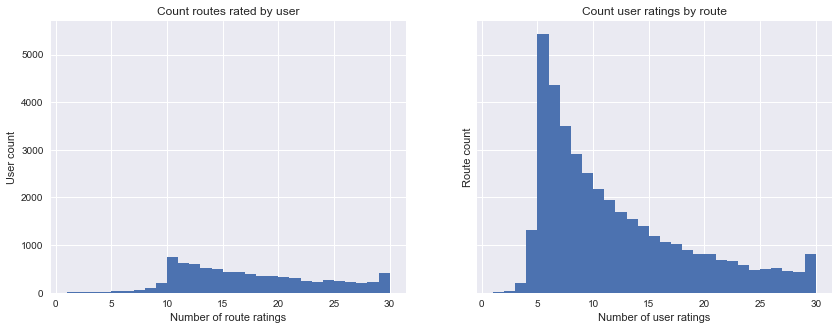

In [165]:
ah.plt_count_hists(ah.rus_chop(df,10,5))

In [149]:
ah.unq_u_r(ah.rus_chop(df,10,0))

(16801, 85491)

### RMSE by cold-start threshold

In [116]:
rus_density_thresh = ah.thresh_density_arr(df_better_sample,30,30)
arr_rmse, arr_mae, arr_fcp = ah.thresh_metrics_arrs(df_better_sample,30,30)

RMSE: 0.7174
MAE:  0.5719
FCP:  0.5634
RMSE: 0.7165
MAE:  0.5699
FCP:  0.5452
RMSE: 0.7068
MAE:  0.5626
FCP:  0.5514
RMSE: 0.6889
MAE:  0.5461
FCP:  0.5618
RMSE: 0.6886
MAE:  0.5472
FCP:  0.5532
RMSE: 0.6800
MAE:  0.5398
FCP:  0.5586
RMSE: 0.6693
MAE:  0.5290
FCP:  0.5593
RMSE: 0.6643
MAE:  0.5274
FCP:  0.5686
RMSE: 0.6606
MAE:  0.5236
FCP:  0.5839
RMSE: 0.6555
MAE:  0.5204
FCP:  0.5791
RMSE: 0.6454
MAE:  0.5130
FCP:  0.5818
RMSE: 0.6455
MAE:  0.5122
FCP:  0.5895
RMSE: 0.6411
MAE:  0.5088
FCP:  0.5793
RMSE: 0.6404
MAE:  0.5069
FCP:  0.5886
RMSE: 0.6446
MAE:  0.5103
FCP:  0.5728
RMSE: 0.6403
MAE:  0.5052
FCP:  0.5828
RMSE: 0.6283
MAE:  0.4976
FCP:  0.5925
RMSE: 0.6366
MAE:  0.5009
FCP:  0.6047
RMSE: 0.6291
MAE:  0.4969
FCP:  0.5873
RMSE: 0.6361
MAE:  0.5026
FCP:  0.5984
RMSE: 0.6297
MAE:  0.4963
FCP:  0.5941
RMSE: 0.6292
MAE:  0.4970
FCP:  0.6128
RMSE: 0.6359
MAE:  0.4984
FCP:  0.5913
RMSE: 0.6318
MAE:  0.4955
FCP:  0.6047
RMSE: 0.6252
MAE:  0.4952
FCP:  0.5979
RMSE: 0.6267
MAE:  0.4937

RMSE: 0.7125
MAE:  0.5693
FCP:  0.5573
RMSE: 0.7027
MAE:  0.5608
FCP:  0.5490
RMSE: 0.6942
MAE:  0.5517
FCP:  0.5573
RMSE: 0.6832
MAE:  0.5439
FCP:  0.5637
RMSE: 0.6724
MAE:  0.5354
FCP:  0.5599
RMSE: 0.6628
MAE:  0.5277
FCP:  0.5634
RMSE: 0.6631
MAE:  0.5258
FCP:  0.5667
RMSE: 0.6561
MAE:  0.5206
FCP:  0.5777
RMSE: 0.6458
MAE:  0.5125
FCP:  0.5806
RMSE: 0.6502
MAE:  0.5175
FCP:  0.5695
RMSE: 0.6434
MAE:  0.5104
FCP:  0.5728
RMSE: 0.6384
MAE:  0.5060
FCP:  0.5933
RMSE: 0.6387
MAE:  0.5047
FCP:  0.5924
RMSE: 0.6337
MAE:  0.5026
FCP:  0.5950
RMSE: 0.6315
MAE:  0.5017
FCP:  0.5952
RMSE: 0.6311
MAE:  0.5003
FCP:  0.5948
RMSE: 0.6321
MAE:  0.5005
FCP:  0.6082
RMSE: 0.6351
MAE:  0.5018
FCP:  0.5899
RMSE: 0.6329
MAE:  0.5004
FCP:  0.6014
RMSE: 0.6184
MAE:  0.4915
FCP:  0.5969
RMSE: 0.6214
MAE:  0.4930
FCP:  0.6105
RMSE: 0.6297
MAE:  0.4989
FCP:  0.5989
RMSE: 0.6257
MAE:  0.4934
FCP:  0.6073
RMSE: 0.6171
MAE:  0.4885
FCP:  0.6154
RMSE: 0.6193
MAE:  0.4879
FCP:  0.6070
RMSE: 0.6256
MAE:  0.4928

RMSE: 0.7002
MAE:  0.5571
FCP:  0.5658
RMSE: 0.6931
MAE:  0.5522
FCP:  0.5693
RMSE: 0.6844
MAE:  0.5424
FCP:  0.5583
RMSE: 0.6746
MAE:  0.5403
FCP:  0.5624
RMSE: 0.6661
MAE:  0.5288
FCP:  0.5748
RMSE: 0.6691
MAE:  0.5323
FCP:  0.5754
RMSE: 0.6635
MAE:  0.5278
FCP:  0.5541
RMSE: 0.6538
MAE:  0.5189
FCP:  0.5797
RMSE: 0.6485
MAE:  0.5166
FCP:  0.5786
RMSE: 0.6417
MAE:  0.5104
FCP:  0.5742
RMSE: 0.6404
MAE:  0.5085
FCP:  0.5815
RMSE: 0.6336
MAE:  0.5038
FCP:  0.5921
RMSE: 0.6326
MAE:  0.5029
FCP:  0.5886
RMSE: 0.6299
MAE:  0.4973
FCP:  0.5882
RMSE: 0.6214
MAE:  0.4914
FCP:  0.5929
RMSE: 0.6303
MAE:  0.5009
FCP:  0.5847
RMSE: 0.6264
MAE:  0.4963
FCP:  0.5918
RMSE: 0.6299
MAE:  0.4995
FCP:  0.5892
RMSE: 0.6287
MAE:  0.4964
FCP:  0.5958
RMSE: 0.6280
MAE:  0.4951
FCP:  0.6028
RMSE: 0.6226
MAE:  0.4912
FCP:  0.6007
RMSE: 0.6237
MAE:  0.4945
FCP:  0.6082
RMSE: 0.6201
MAE:  0.4929
FCP:  0.6040
RMSE: 0.6250
MAE:  0.4940
FCP:  0.6021
RMSE: 0.6246
MAE:  0.4908
FCP:  0.6055
RMSE: 0.6228
MAE:  0.4905

FCP:  0.5601
RMSE: 0.6902
MAE:  0.5506
FCP:  0.5559
RMSE: 0.6881
MAE:  0.5491
FCP:  0.5619
RMSE: 0.6867
MAE:  0.5480
FCP:  0.5613
RMSE: 0.6742
MAE:  0.5371
FCP:  0.5697
RMSE: 0.6625
MAE:  0.5271
FCP:  0.5606
RMSE: 0.6606
MAE:  0.5262
FCP:  0.5692
RMSE: 0.6579
MAE:  0.5257
FCP:  0.5820
RMSE: 0.6493
MAE:  0.5155
FCP:  0.5741
RMSE: 0.6460
MAE:  0.5139
FCP:  0.5829
RMSE: 0.6404
MAE:  0.5111
FCP:  0.5885
RMSE: 0.6381
MAE:  0.5082
FCP:  0.5906
RMSE: 0.6416
MAE:  0.5087
FCP:  0.5812
RMSE: 0.6297
MAE:  0.4987
FCP:  0.5875
RMSE: 0.6335
MAE:  0.5024
FCP:  0.5952
RMSE: 0.6385
MAE:  0.5051
FCP:  0.5980
RMSE: 0.6294
MAE:  0.4997
FCP:  0.6061
RMSE: 0.6244
MAE:  0.4979
FCP:  0.5959
RMSE: 0.6230
MAE:  0.4963
FCP:  0.6090
RMSE: 0.6254
MAE:  0.4957
FCP:  0.6005
RMSE: 0.6257
MAE:  0.4916
FCP:  0.5969
RMSE: 0.6170
MAE:  0.4868
FCP:  0.6117
RMSE: 0.6201
MAE:  0.4917
FCP:  0.5963
RMSE: 0.6196
MAE:  0.4891
FCP:  0.6004
RMSE: 0.6274
MAE:  0.4926
FCP:  0.6097
RMSE: 0.6173
MAE:  0.4880
FCP:  0.6183
RMSE: 0.6192

FCP:  0.5630
RMSE: 0.6987
MAE:  0.5584
FCP:  0.5547
RMSE: 0.6944
MAE:  0.5534
FCP:  0.5614
RMSE: 0.6791
MAE:  0.5421
FCP:  0.5687
RMSE: 0.6750
MAE:  0.5397
FCP:  0.5711
RMSE: 0.6694
MAE:  0.5328
FCP:  0.5699
RMSE: 0.6634
MAE:  0.5280
FCP:  0.5836
RMSE: 0.6564
MAE:  0.5255
FCP:  0.5597
RMSE: 0.6506
MAE:  0.5181
FCP:  0.5807
RMSE: 0.6467
MAE:  0.5140
FCP:  0.5737
RMSE: 0.6425
MAE:  0.5119
FCP:  0.5851
RMSE: 0.6404
MAE:  0.5078
FCP:  0.5799
RMSE: 0.6319
MAE:  0.5000
FCP:  0.5868
RMSE: 0.6363
MAE:  0.5055
FCP:  0.5795
RMSE: 0.6296
MAE:  0.5010
FCP:  0.5951
RMSE: 0.6315
MAE:  0.5019
FCP:  0.5826
RMSE: 0.6222
MAE:  0.4966
FCP:  0.5914
RMSE: 0.6318
MAE:  0.5025
FCP:  0.5949
RMSE: 0.6280
MAE:  0.4974
FCP:  0.5991
RMSE: 0.6246
MAE:  0.4940
FCP:  0.5917
RMSE: 0.6262
MAE:  0.4983
FCP:  0.6137
RMSE: 0.6188
MAE:  0.4897
FCP:  0.6088
RMSE: 0.6155
MAE:  0.4892
FCP:  0.6073
RMSE: 0.6126
MAE:  0.4842
FCP:  0.6120
RMSE: 0.6268
MAE:  0.4933
FCP:  0.6028
RMSE: 0.6169
MAE:  0.4865
FCP:  0.5976
RMSE: 0.6205

In the plots below, I fit the 'Funk style SVD' algorithm from the `surprise` package to a training set from our `df_better_sample`. We then plot the RMSE while varying the cold-start threshold.
 - Raising the user threshold up to about 10 clearly improves the predictive power of our model. After that we hit diminishing returns and begin to see some noise.
 - The effect of raising the route threshold is less clear. There seems to be some improvement 
 - However, as it turns out, by removing routes we end up removing some of the 'information' that we are using to predict users ratings. As a result, once we raise the threshold beyond 5 we see a lot of noise and even a trend upward in RMSE.
 
With the Surprise SVD algorithm, cold-start users will receive predicted scores based on the 'average user', which as it turns out is still very useful in our recommender engine. Therefore I'm okay with raising the user rating threshold to 10 and thereby giving personalized recommendations to **30%** of our userbase. Once we meet this threshold we have enough info to give a user **personalized** recommendations.

I'm going to cut routes off for the model at a cold-start threshold of 3, because less trafficked routes tend to be obscure and there is some noise / bad data and routes that don't actually exist in this region. Routes in the 3-10 region it seems may provide the model with some useful information, however, they still wouldn't be considered **classics** and I want my recommender to return well-known and quality routes so I am going to include these routes in the model, but remove them from the recommender.

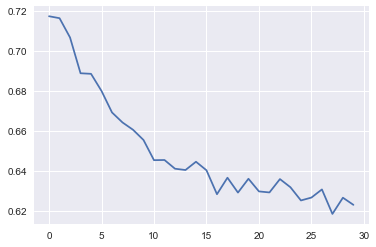

In [140]:
#RMSE by user threshold
#functionalize and label prettify, Add survivorship to this
plt.plot(arr_rmse[0])

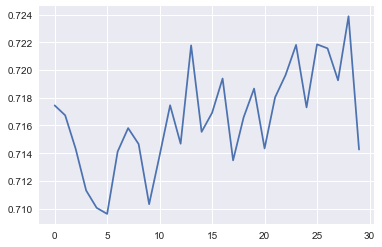

In [168]:
#RMSE by user threshold
#functionalize and label prettify
plt.plot(arr_rmse[:,0])

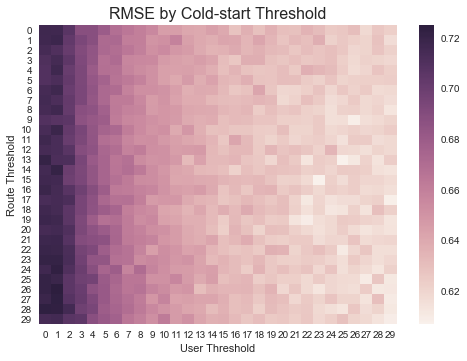

In [118]:
ah.thresh_heatmap(arr_rmse,"RMSE by Cold-start Threshold")

### Grid Search SVD & SVD++

- SVD ++ takes into account 'implicit' ratings - ie if a user is more likely to rate something if they like it. 
- hypthesis: this doesn't help since what users climb often depends on where they live 

In [184]:
df_chopped_u10_r3 = ah.rus_chop(df,10,3)
ah.pr_mat_stats(df_chopped_u10_r3)
print('SVD out of the box RMSE: {}'.format(round(arr_rmse[10,3],3)))

Matrix Stats
---------------------
matrix size: 1111622400
matrix shape: users 66168, routes 16800
matrix density: 0.0012403249520700555
SVD out of the box RMSE: 0.695


In [188]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
data = Dataset.load_from_df(df_chopped_u10_r3, reader=reader)
trainset, testset = train_test_split(data, test_size=.2)

In [193]:
algo_pp = SVDpp()
algo_pp.fit(trainset)
predictions = algo_pp.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6299


0.6299178003412865

In [195]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
ah.suprise_gridsearch(data,SVD,param_grid)

Process ForkPoolWorker-2:
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/colinbrochard/anaconda/lib/python3.6/site-packages/joblib/pool.py", line 362, in get
    return recv()
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/colinbrochard/anaconda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt: 

### Appendix

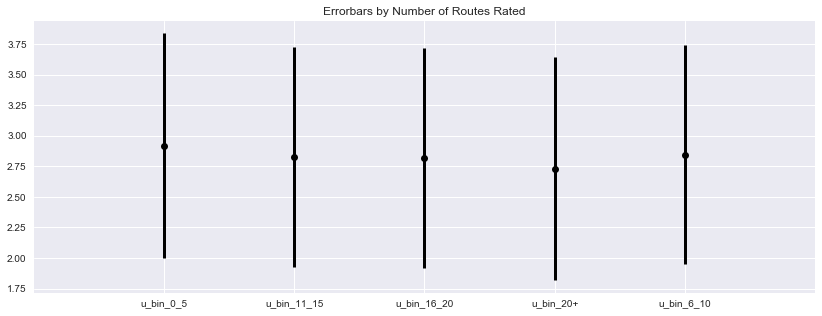

In [129]:
ah.plot_errorbars(df)

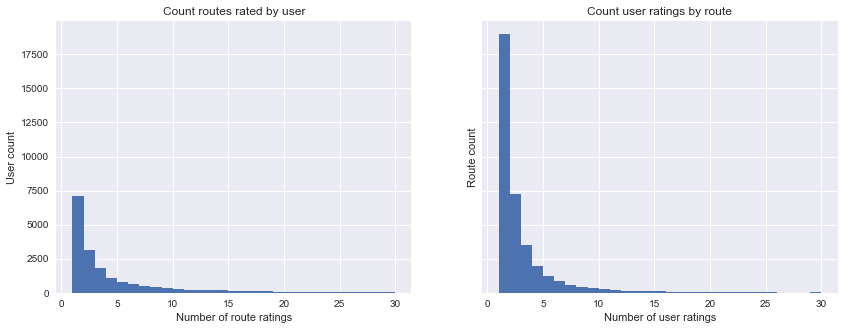

In [82]:
ah.plt_count_hists(df_sample)

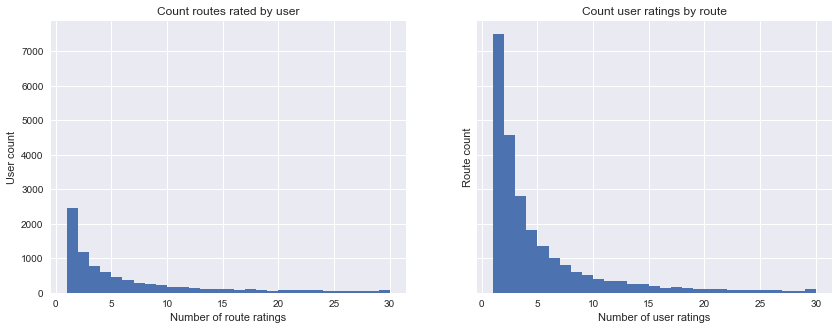

In [83]:
ah.plt_count_hists(df_better_sample)

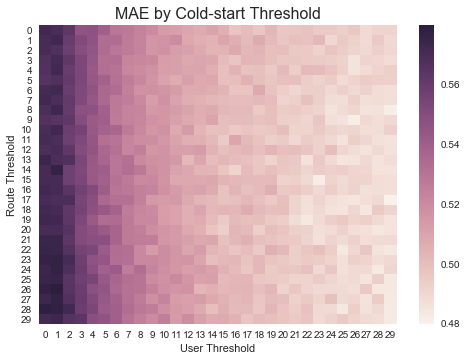

In [119]:
ah.thresh_heatmap(arr_mae,"MAE by Cold-start Threshold")

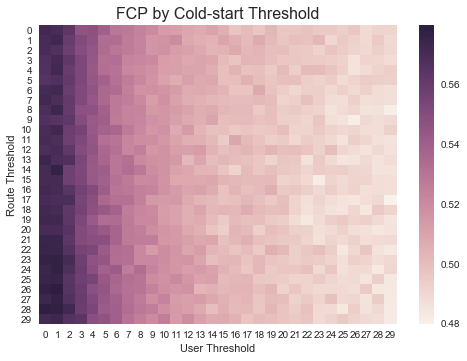

In [120]:
ah.thresh_heatmap(arr_fcp,"FCP by Cold-start Threshold")